In [31]:
import json
import os
import sys
import numpy as np
#create plots
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import copy
from scipy.stats import pearsonr
from numpy.polynomial.polynomial import Polynomial

### define plotting code and files loading

In [32]:
def extract_files(judge_name:str, path:str, data_file:str):
    file_paths = []
    for r, d, f in os.walk(path):
        for file in f:
            if data_file+judge_name in file and '.json' in file:
                file_paths.append(file)
    return file_paths

def compute_kappa_p(cobs, p_cor, p_wrong, op_len_sum, num_qs):
    avg_options = op_len_sum / num_qs
    normalise = 1 / (avg_options - 1)
    cexp = p_cor + p_wrong * normalise
    score = (cobs - cexp) / (1 - cexp)
    return score 

def create_data_table(data_table:dict,judge_name:str, path:str, file_path:list, judge_scores:pd.DataFrame, exclude:list[str]=[]):
    
    judge_column = 'accuracy_' + judge_name.split('__')[1]
    #load files and compute value of the similarity
    for file in file_path:
        with open(path + '/' + file) as f:
            data = json.load(f)
            model_name = file.split('___')[2].split('.json')[0]
            model_family = model_name.split('__')[0]

            if judge_name == model_name:
                print(f'Model and Judge name are the same {judge_name} == {model_name}, skipping')
            
            else:
                if model_name in exclude:
                    print(f"Model {model_name} is in the exclude list, skipping")
                    continue
                else:
                    if "Meta-Llama-3.1" in model_name:
                        model_name_sr= model_name.replace("Meta-Llama-3.1", "Llama-3.1")
                    
                    else:
                        model_name_sr = model_name

                    if judge_scores[judge_column][judge_scores['model']==model_name_sr].values.size > 0:
                        data_table["scores"].append(judge_scores[judge_column][judge_scores['model']==model_name_sr].values[0])
                        data_table["model"].append(model_name)
                        data_table["accuracy"].append(data['accuracies'][model_name])
                        data_table["score-accuracy"].append(judge_scores[judge_column][judge_scores['model']==model_name_sr].values[0] - data['accuracies'][model_name])
                        data_table["similarity"].append(data['probkappa']['score'])
                        data_table["model_family"].append(model_family)
                    else:
                        print(f"Model not found in the judge scores, model {model_name}, skipping")
                
    return data_table


def create_marker_types(judges:list[str]):
    marker_types = []
    for i in range(len(judges)):
        iteration = {}
        for judge in judges:
            judge_family = judge.split('__')[0]
            if judge_family not in iteration:
                iteration[judge_family] = 'o'
        marker_types.append(iteration)

    return marker_types


palette = {
    'Qwen': 'b',
    'tiiuae': 'g',
    'microsoft': 'r',
    'HuggingFaceTB': 'm',
    'meta-llama': 'y',
    'google': 'c'
}


### Define judges and Model paths

In [33]:
#load judge scores
#load csv file
judge_scores = pd.read_csv('../data/judge_scores.csv')
#fix column name
judge_scores.rename(columns={"accuracy_Llama-3.1-8B-Instruct": "accuracy_Meta-Llama-3.1-8B-Instruct"}, inplace=True)
print(judge_scores.columns.sort_values())

Index(['accuracy_Llama-3.3-70B-Instruct',
       'accuracy_Meta-Llama-3.1-70B-Instruct',
       'accuracy_Meta-Llama-3.1-8B-Instruct',
       'accuracy_Ministral-8B-Instruct-2410', 'accuracy_Qwen2.5-32B-Instruct',
       'accuracy_Qwen2.5-72B-Instruct', 'accuracy_Qwen2.5-7B-Instruct',
       'accuracy_gemma-2-27b-it', 'accuracy_gemma-2-9b-it', 'accuracy_phi-4',
       'model'],
      dtype='object')


In [34]:
judge_scores.model.sort_values().unique()

array(['HuggingFaceTB__SmolLM2-1.7B',
       'HuggingFaceTB__SmolLM2-1.7B-Instruct',
       'HuggingFaceTB__SmolLM2-135M-Instruct',
       'HuggingFaceTB__SmolLM2-360M',
       'HuggingFaceTB__SmolLM2-360M-Instruct', 'Qwen__Qwen2.5-0.5B',
       'Qwen__Qwen2.5-0.5B-Instruct', 'Qwen__Qwen2.5-1.5B',
       'Qwen__Qwen2.5-1.5B-Instruct', 'Qwen__Qwen2.5-14B',
       'Qwen__Qwen2.5-14B-Instruct', 'Qwen__Qwen2.5-32B',
       'Qwen__Qwen2.5-32B-Instruct', 'Qwen__Qwen2.5-3B',
       'Qwen__Qwen2.5-3B-Instruct', 'Qwen__Qwen2.5-72B',
       'Qwen__Qwen2.5-72B-Instruct', 'Qwen__Qwen2.5-7B',
       'Qwen__Qwen2.5-7B-Instruct', 'google__gemma-2-27b',
       'google__gemma-2-27b-it', 'google__gemma-2-2b',
       'google__gemma-2-2b-it', 'google__gemma-2-9b',
       'google__gemma-2-9b-it', 'meta-llama__Llama-3.1-70B',
       'meta-llama__Llama-3.1-70B-Instruct', 'meta-llama__Llama-3.1-8B',
       'meta-llama__Llama-3.1-8B-Instruct', 'meta-llama__Llama-3.2-1B',
       'meta-llama__Llama-3.2-1B-Instru

In [35]:
#define judges
judges = [ "Qwen/Qwen2.5-7B-Instruct",
              "Qwen/Qwen2.5-32B-Instruct",
              "Qwen/Qwen2.5-72B-Instruct",
              "meta-llama/Meta-Llama-3.1-8B-Instruct",
              "meta-llama/Meta-Llama-3.1-70B-Instruct",
              "meta-llama/Llama-3.3-70B-Instruct",
              "google/gemma-2-9b-it",
              "google/gemma-2-27b-it",
              "mistralai/Ministral-8B-Instruct-2410",
]
judges = [judge_name.replace("/", "__") for judge_name in judges]
exclude = ['microsoft__Phi-3.5-MoE-instruct', 'microsoft__Phi-3.5-mini-instruct']
data_file = 'similarity___'
path = '../output/sim'
marker_types = create_marker_types(judge_scores.model)

### Load data

In [36]:
data_loaded = {}
for i,judge_name in enumerate(judges):
    filenames = extract_files(judge_name, path, data_file)
    data_table = {"model":[],"scores":[],"similarity":[], "accuracy":[], "model_family":[], "score-accuracy":[]}
    data_table = create_data_table(data_table, judge_name, path, filenames, judge_scores, exclude)
    df_data_table = pd.DataFrame(data_table)
    data_loaded[judge_name] = df_data_table

Model microsoft__Phi-3.5-mini-instruct is in the exclude list, skipping
Model and Judge name are the same Qwen__Qwen2.5-7B-Instruct == Qwen__Qwen2.5-7B-Instruct, skipping
Model microsoft__Phi-3.5-MoE-instruct is in the exclude list, skipping
Model microsoft__Phi-3.5-mini-instruct is in the exclude list, skipping
Model microsoft__Phi-3.5-MoE-instruct is in the exclude list, skipping
Model and Judge name are the same Qwen__Qwen2.5-32B-Instruct == Qwen__Qwen2.5-32B-Instruct, skipping
Model microsoft__Phi-3.5-mini-instruct is in the exclude list, skipping
Model microsoft__Phi-3.5-MoE-instruct is in the exclude list, skipping
Model and Judge name are the same Qwen__Qwen2.5-72B-Instruct == Qwen__Qwen2.5-72B-Instruct, skipping
Model microsoft__Phi-3.5-MoE-instruct is in the exclude list, skipping
Model microsoft__Phi-3.5-mini-instruct is in the exclude list, skipping
Model and Judge name are the same meta-llama__Meta-Llama-3.1-8B-Instruct == meta-llama__Meta-Llama-3.1-8B-Instruct, skipping
Mo

In [37]:
combined_data = pd.DataFrame()

for judge_name in judges:
    df_data_table = data_loaded[judge_name]
    df_data_table['judge'] = judge_name.split('__')[1]
    combined_data = pd.concat([combined_data, df_data_table], ignore_index=True)

In [38]:
combined_data

,model,scores,similarity,accuracy,model_family,score-accuracy,judge
0,google__gemma-2-2b-it,0.342483,0.160989,0.265515,google,0.076968,Qwen2.5-7B-Instruct
1,Qwen__Qwen2.5-1.5B-Instruct,0.358677,0.198367,0.273688,Qwen,0.084989,Qwen2.5-7B-Instruct
2,meta-llama__Meta-Llama-3.1-8B-Instruct,0.377397,0.207193,0.361526,meta-llama,0.015871,Qwen2.5-7B-Instruct
3,google__gemma-2-27b,0.427357,0.166165,0.409101,google,0.018256,Qwen2.5-7B-Instruct
4,google__gemma-2-9b,0.384748,0.166668,0.392898,google,-0.008150,Qwen2.5-7B-Instruct
...,...,...,...,...,...,...,...
338,Qwen__Qwen2.5-3B-Instruct,0.421844,0.165000,0.312543,Qwen,0.109301,Ministral-8B-Instruct-2410
339,Qwen__Qwen2.5-0.5B-Instruct,0.249684,0.028964,0.174592,Qwen,0.075092,Ministral-8B-Instruct-2410
340,HuggingFaceTB__SmolLM2-360M-Instruct,0.170113,-0.002161,0.108890,HuggingFaceTB,0.061222,Ministral-8B-Instruct-2410
341,HuggingFaceTB__SmolLM2-135M-Instruct,0.080740,0.033963,0.105904,HuggingFaceTB,-0.025164,Ministral-8B-Instruct-2410


In [39]:
print(f'Number of judges: {len(judges)}')
print(f'Number of models: {len(combined_data["model"].unique())}')

Number of judges: 9
Number of models: 39


## General Results: Trend Score vs Similarity

#### Correlation (Pearson's)

In [40]:
pearson_corr_sim_acc = {}

#added to the plots above to show the pearson correlation
for judge_name in judges:
    r, p_value = pearsonr(data_loaded[judge_name]['similarity'],data_loaded[judge_name]['accuracy'],)
    pearson_corr_sim_acc[judge_name] = (r, p_value)
    print(f"Pearson correlation for {judge_name} is {r:.2f} with p-value {p_value:.5f}")

Pearson correlation for Qwen__Qwen2.5-7B-Instruct is 0.87 with p-value 0.00000
Pearson correlation for Qwen__Qwen2.5-32B-Instruct is 0.88 with p-value 0.00000
Pearson correlation for Qwen__Qwen2.5-72B-Instruct is 0.88 with p-value 0.00000
Pearson correlation for meta-llama__Meta-Llama-3.1-8B-Instruct is 0.82 with p-value 0.00000
Pearson correlation for meta-llama__Meta-Llama-3.1-70B-Instruct is 0.89 with p-value 0.00000
Pearson correlation for meta-llama__Llama-3.3-70B-Instruct is 0.89 with p-value 0.00000
Pearson correlation for google__gemma-2-9b-it is 0.82 with p-value 0.00000
Pearson correlation for google__gemma-2-27b-it is 0.85 with p-value 0.00000
Pearson correlation for mistralai__Ministral-8B-Instruct-2410 is 0.75 with p-value 0.00000


In [41]:
pearson_corr_score_acc = {}

#added to the plots above to show the pearson correlation
for judge_name in judges:
    r, p_value = pearsonr(data_loaded[judge_name]['scores'],data_loaded[judge_name]['accuracy'],)
    pearson_corr_score_acc[judge_name] = (r, p_value)
    print(f"Pearson correlation for {judge_name} is {r:.2f} with p-value {p_value:.5f}")

Pearson correlation for Qwen__Qwen2.5-7B-Instruct is 0.93 with p-value 0.00000
Pearson correlation for Qwen__Qwen2.5-32B-Instruct is 0.94 with p-value 0.00000
Pearson correlation for Qwen__Qwen2.5-72B-Instruct is 0.95 with p-value 0.00000
Pearson correlation for meta-llama__Meta-Llama-3.1-8B-Instruct is 0.90 with p-value 0.00000
Pearson correlation for meta-llama__Meta-Llama-3.1-70B-Instruct is 0.94 with p-value 0.00000
Pearson correlation for meta-llama__Llama-3.3-70B-Instruct is 0.94 with p-value 0.00000
Pearson correlation for google__gemma-2-9b-it is 0.93 with p-value 0.00000
Pearson correlation for google__gemma-2-27b-it is 0.93 with p-value 0.00000
Pearson correlation for mistralai__Ministral-8B-Instruct-2410 is 0.90 with p-value 0.00000


In [42]:
pearson_corr = {}
r_avg = 0

#added to the plots above to show the pearson correlation
for judge_name in judges:
    r, p_value = pearsonr(data_loaded[judge_name]['scores'], data_loaded[judge_name]['similarity'])
    if p_value < 0.01:
        pearson_corr[judge_name] = (r, 0.01)
    else:
        pearson_corr[judge_name] = (r, p_value)
    r_avg += r
    print(f"Pearson correlation for {judge_name} is {r:.2f} with {p_value:.5f}, n={len(data_loaded[judge_name])}")

print(f"Average Pearson correlation: {r_avg/len(judges):.2f}")

Pearson correlation for Qwen__Qwen2.5-7B-Instruct is 0.92 with 0.00000, n=38
Pearson correlation for Qwen__Qwen2.5-32B-Instruct is 0.90 with 0.00000, n=38
Pearson correlation for Qwen__Qwen2.5-72B-Instruct is 0.90 with 0.00000, n=38
Pearson correlation for meta-llama__Meta-Llama-3.1-8B-Instruct is 0.90 with 0.00000, n=38
Pearson correlation for meta-llama__Meta-Llama-3.1-70B-Instruct is 0.90 with 0.00000, n=38
Pearson correlation for meta-llama__Llama-3.3-70B-Instruct is 0.89 with 0.00000, n=38
Pearson correlation for google__gemma-2-9b-it is 0.90 with 0.00000, n=38
Pearson correlation for google__gemma-2-27b-it is 0.91 with 0.00000, n=38
Pearson correlation for mistralai__Ministral-8B-Instruct-2410 is 0.84 with 0.00000, n=39
Average Pearson correlation: 0.90


In [43]:
def create_palette_judges(orignal_palette, judges):
    new_palette = {}
    for i,judge in enumerate(judges):
        if judge == 'Qwen__Qwen2.5-72B-Instruct':
            new_palette[judge] = (0., 0., 1.0)
        elif judge == 'meta-llama__Meta-Llama-3.1-8B-Instruct':
            new_palette[judge] = (0.6, 1.0, 0.22)
        elif judge == 'meta-llama__Meta-Llama-3.1-70B-Instruct':
            new_palette[judge] = (0.3, 0.8, 0.)
        elif judge == 'meta-llama__Llama-3.3-70B-Instruct':
             new_palette[judge] = (0., 0.55, 0.09)
        elif judge == 'mistralai__Ministral-8B-Instruct-2410':
            new_palette[judge] = (1., 0., 0.)
        else:
            new_palette[judge] = orignal_palette[i]
        
    return new_palette    

def create_linestyles_judges(judges):
    judge_family = set([judge.split('__')[0] for judge in judges])
    linestyles_tmp = {}
    linestyles = ['-', '--', '-.', ':']
    linestyles_list_comp = []
    for idx, judge in enumerate(judge_family):
        linestyles_tmp[judge] = linestyles[idx]

    for judge in judges:
        linestyles_list_comp.append(linestyles_tmp[judge.split('__')[0]])

    return linestyles_tmp
        



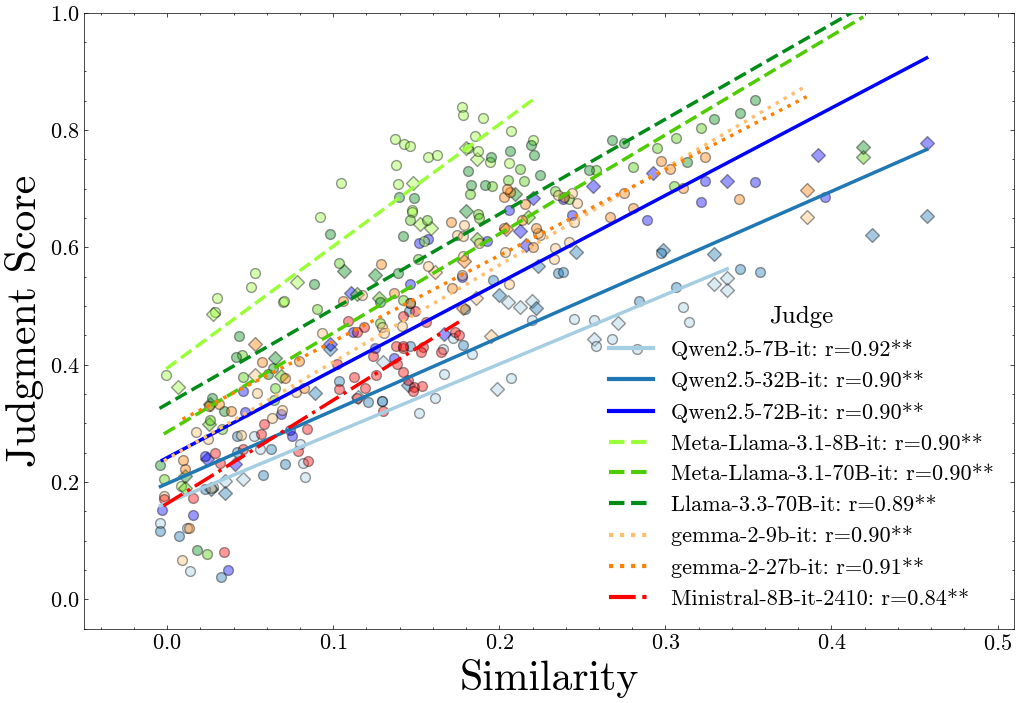

In [44]:
plt.style.use(['science', 'no-latex']) #, 'high-vis'])

fig, ax = plt.subplots(figsize=(12, 8))

for i,judge_name in enumerate(judges):
    marker_types[i][judge_name.split('__')[0]] = 'D'

# # # Define a new color palette
new_palette = sns.color_palette("Paired", len(judges))

palette_judges = create_palette_judges(new_palette, judges)
linestyles = create_linestyles_judges(judges)

# Plot scatter and regression lines for each judge
for judge_name in judges:
    judge_label = judge_name.split('__')[1]
    subset = combined_data[combined_data['judge'] == judge_label]

    # Plot regression line
    x = subset["similarity"]
    y = subset["scores"]
    m, b = np.polyfit(x, y, 1)
    x_plot = np.linspace(x.min(), x.max(), 50)
    ax.plot(x_plot, m*x_plot + b, label=judge_label, alpha=1, zorder=3, linewidth=2.5, linestyle=linestyles[judge_name.split('__')[0]], color=palette_judges[judge_name])

    # Plot scatter points
    for model_family in subset['model_family'].unique():
        family_subset = subset[subset['model_family'] == model_family]
        ax.scatter(family_subset["similarity"], family_subset["scores"], marker=marker_types[judges.index(judge_name)][model_family], 
                zorder=1, s=50, alpha=0.4, edgecolor='black', c=[palette_judges[judge_name]])
        


handles, labels = ax.get_legend_handles_labels()
#copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(3) for ha in handles ]

#labels = [f'{label.replace("Instruct", "it")}: r={pearson_corr[judges[i]][0]:.2f}, p-val$<${pearson_corr[judges[i]][1]}' for i, label in enumerate(labels)]
labels = [f'{label.replace("Instruct", "it")}: r={pearson_corr[judges[i]][0]:.2f}**' for i, label in enumerate(labels)]
ax.legend(handles[:len(judges)], labels, title="Judge", loc='lower right', fontsize=16, title_fontsize=18)

ax.set_xlim(-0.05, 0.51)
ax.set_ylim(-0.05, 1)
ax.set_xlabel("Similarity", fontsize=30)
ax.set_ylabel("Judgment Score", fontsize=30)
#ax.set_title("Judgment Scores vs Similarity across Judges", fontsize=20)

# Increase tick size
ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../plots/judgement_scores_vs_similarity.png', dpi=300)
plt.show()

### Correlation Analysis accounting for the Confounder Accuracy

#### Partial Correlation

A straightforward way to address whether judgment score is independent of similarity score once accuracy is accounted for is to compute the partial correlation (or partial correlation coefficient) between judgment and similarity, controlling for accuracy.

Both judgment and similarity may be correlated with (i.e., confounded by) accuracy. Partial correlation lets you measure the relationship between two variables (judgment, similarity) while “partialing out” the variance they each share with a third variable (accuracy).

Interpretation: A partial correlation of zero between judgment and similarity (controlling for accuracy) would indicate that judgment and similarity do not have a meaningful association once accuracy is accounted for.

In [45]:
#compute partial correlation
import pingouin as pg

partial_correlation = pd.DataFrame()
for i,judge_name in enumerate(judges):
    #  Compute partial correlation
    #    We want the correlation between judgment and similarity
    #    controlling for accuracy.
    pcorr = pg.partial_corr(data=data_loaded[judge_name], x='scores', y='similarity', covar='accuracy', method='pearson')
    pcorr['judge'] = judge_name.split('__')[1]
    partial_correlation = pd.concat([partial_correlation, pcorr], ignore_index=True)
partial_correlation = partial_correlation[['judge', 'n' ,'r',  'CI95%', 'p-val']]


In [46]:
partial_correlation

,judge,n,r,CI95%,p-val
0,Qwen2.5-7B-Instruct,38,0.600433,"[0.34, 0.77]",0.000085
1,Qwen2.5-32B-Instruct,38,0.433764,"[0.13, 0.66]",0.007316
2,Qwen2.5-72B-Instruct,38,0.423529,"[0.12, 0.66]",0.009001
3,Meta-Llama-3.1-8B-Instruct,38,0.651715,"[0.42, 0.81]",0.000012
4,Meta-Llama-3.1-70B-Instruct,38,0.447704,"[0.14, 0.67]",0.005460
5,Llama-3.3-70B-Instruct,38,0.348816,"[0.03, 0.6]",0.034353
6,gemma-2-9b-it,38,0.646387,"[0.41, 0.8]",0.000015
7,gemma-2-27b-it,38,0.648080,"[0.41, 0.8]",0.000014
8,Ministral-8B-Instruct-2410,39,0.597449,"[0.34, 0.77]",0.000075


In [47]:
# Generate the LaTeX table
latex_table = partial_correlation.to_latex(index=False, header=True, float_format="%.5f")

In [48]:
print(latex_table)

\begin{tabular}{lrrlr}
\toprule
judge & n & r & CI95% & p-val \\
\midrule
Qwen2.5-7B-Instruct & 38 & 0.60043 & [0.34 0.77] & 0.00009 \\
Qwen2.5-32B-Instruct & 38 & 0.43376 & [0.13 0.66] & 0.00732 \\
Qwen2.5-72B-Instruct & 38 & 0.42353 & [0.12 0.66] & 0.00900 \\
Meta-Llama-3.1-8B-Instruct & 38 & 0.65172 & [0.42 0.81] & 0.00001 \\
Meta-Llama-3.1-70B-Instruct & 38 & 0.44770 & [0.14 0.67] & 0.00546 \\
Llama-3.3-70B-Instruct & 38 & 0.34882 & [0.03 0.6 ] & 0.03435 \\
gemma-2-9b-it & 38 & 0.64639 & [0.41 0.8 ] & 0.00002 \\
gemma-2-27b-it & 38 & 0.64808 & [0.41 0.8 ] & 0.00001 \\
Ministral-8B-Instruct-2410 & 39 & 0.59745 & [0.34 0.77] & 0.00007 \\
\bottomrule
\end{tabular}



#### Multiple Linear Regression

Fit a regression models as:

judgement = beta0 + beta1 x similarity + beta2 x accuracy + epsilon

By fitting this model we can see whether similairty has a significant effect on judgement *after controlling for accuracy*

In [49]:
import scipy.stats 
import statsmodels 
import statsmodels.api as sm
from statsmodels.formula.api import ols

def check_assumptions(fitted_model, model_name:str):
    plt.style.use(['science', 'no-latex']) #, 'high-vis'])
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Q-Q plot of residuals
    sm.qqplot(fitted_model.resid, line='s', ax=axs[0])
    axs[0].set_title("Q-Q Plot of Residuals")

    # Residual plot
    #need to look like random scatter, without clear patterns or 'funnel' shapes
    sns.residplot(x=fitted_model.fittedvalues, y=fitted_model.resid, ax=axs[1])
    axs[1].set_xlabel("Fitted values")
    axs[1].set_ylabel("Residuals")
    axs[1].set_title("Residual Plot")

    plt.tight_layout()
    plt.savefig('../plots/residuals_plots_'+model_name+ '.png', dpi=300)

    # Shapiro-Wilk test for normality
    stat, p_val = scipy.stats.shapiro(fitted_model.resid)
    print(f"Shapiro-Wilk Test for Normality: Statistic={stat:.3f}, (p-value={p_val:.3f}).")

    if p_val < 0.05:
        print("Residuals are likely not normally distributed.")
    else:
        print("Residuals are likely normally distributed.")

    # Breusch-Pagan test for homoscedasticity
    # Breusch-Pagan test
    # H0: homoscedasticity (constant variance)
    # H1: heteroscedasticity (non-constant variance)

    labels = ['Lagrange Multiplier statistic', 'p-value', 'F-value', 'p-value']
    test_result = statsmodels.stats.diagnostic.het_breuschpagan(fitted_model.resid, fitted_model.model.exog)

    print(f"Breusch-Pagan test for homoscedasticity:")
    for name, val in zip(labels, test_result):
        if name == 'p-value':
            print(f"({name}: {val:.3f})")
        else:
            print(f"{name}: {val:.3f}")

    lm_stat, lm_pval, f_stat, f_pval = test_result

    if lm_pval < 0.05:
        print("Evidence of heteroscedasticity (non-constant variance).")
    else:
        print("No evidence of heteroscedasticity (the residuals have a constant variance, homoscedasticity met).")
    




 Judge: Qwen2.5-7B-Instruct

\begin{tabular}{llll}
\toprule
\midrule
Model: & OLS & Adj. R-squared: & 0.908 \\
Dependent Variable: & scores & AIC: & -134.3091 \\
Date: & 2025-01-30 22:50 & BIC: & -129.3963 \\
No. Observations: & 38 & Log-Likelihood: & 70.155 \\
Df Model: & 2 & F-statistic: & 182.9 \\
Df Residuals: & 35 & Prob (F-statistic): & 2.95e-19 \\
R-squared: & 0.913 & Scale: & 0.0015837 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
 & Coef. & Std.Err. & t & P>|t| & [0.025 & 0.975] \\
\midrule
Intercept & 0.092 & 0.019 & 4.885 & 0.000 & 0.054 & 0.131 \\
similarity & 0.586 & 0.132 & 4.442 & 0.000 & 0.318 & 0.853 \\
accuracy & 0.506 & 0.098 & 5.185 & 0.000 & 0.308 & 0.704 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
\midrule
Omnibus: & 2.363 & Durbin-Watson: & 2.097 \\
Prob(Omnibus): & 0.307 & Jarque-Bera (JB): & 1.400 \\
Skew: & -0.437 & Prob(JB): & 0.496 \\
Kurtosis: & 3.348 & Condition No.: & 27 \\
\bottomrule
\end{tabular}

Shapiro-Wilk Test f

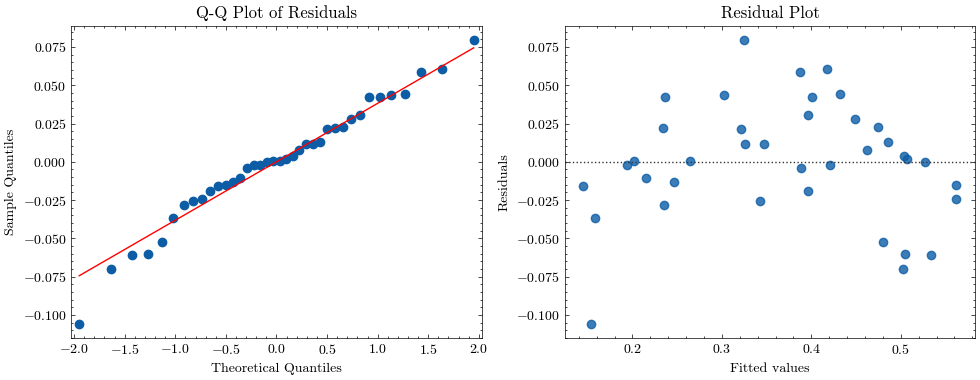

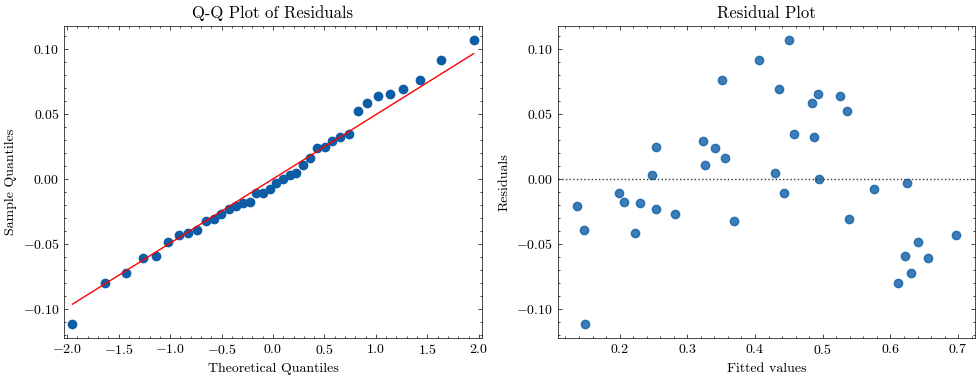

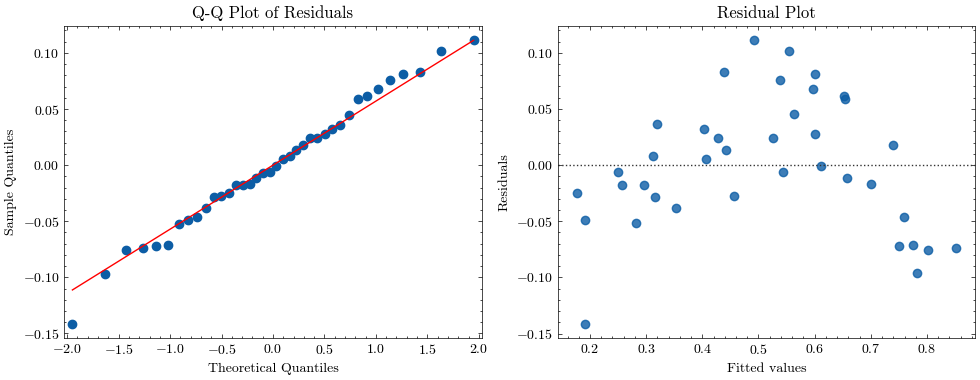

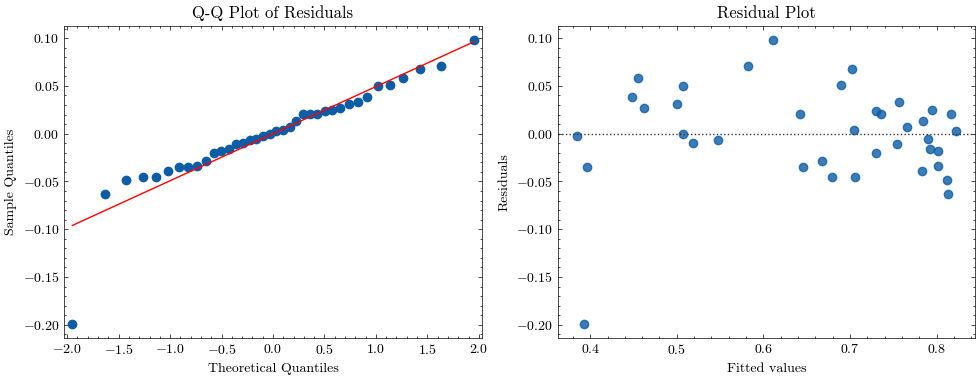

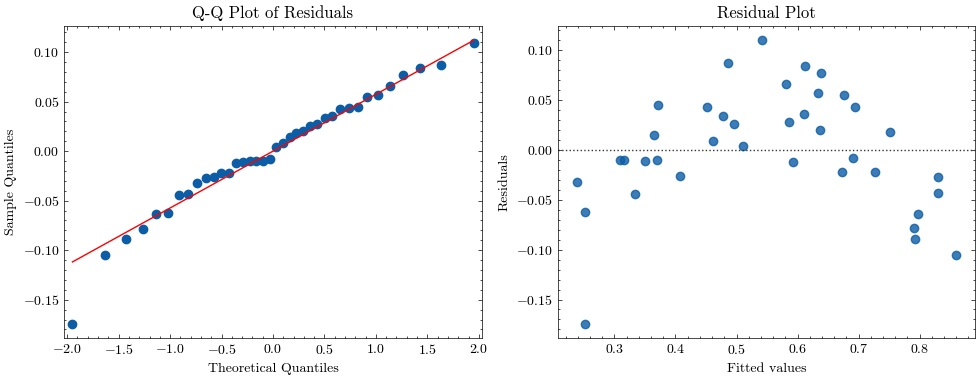

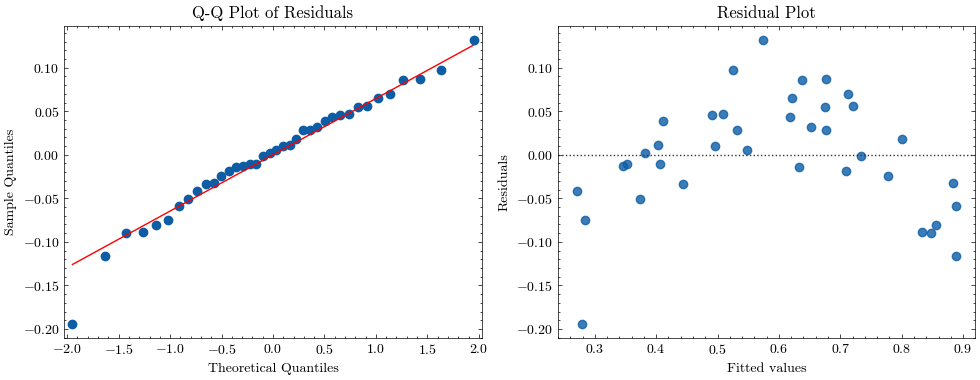

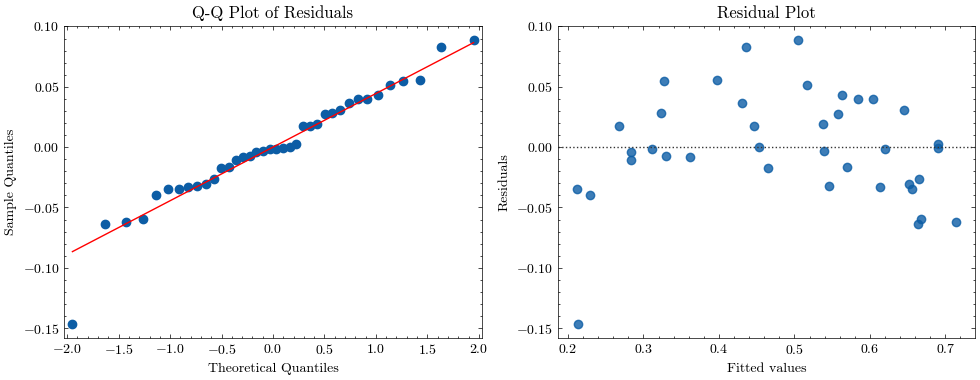

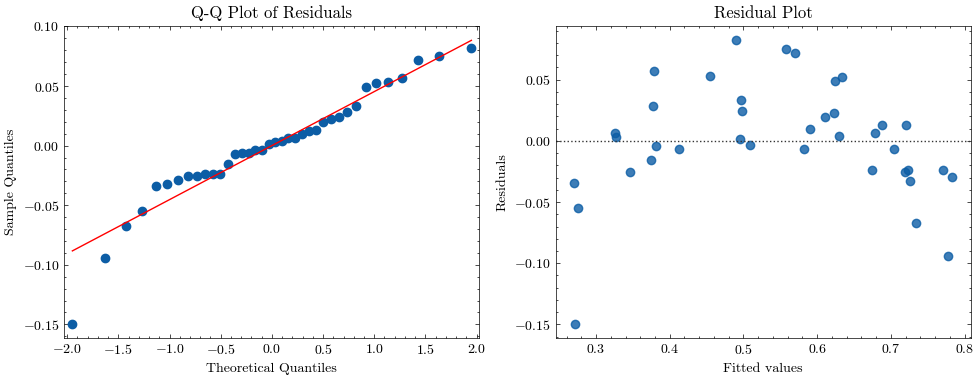

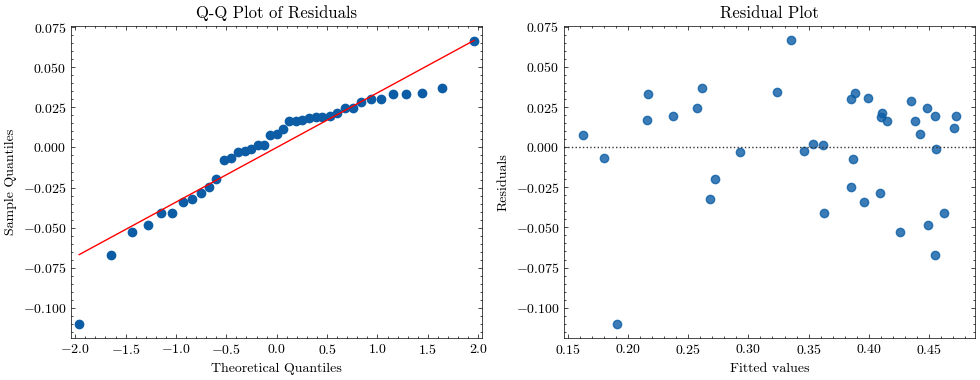

In [50]:
regression_scores = {}


for i,judge_name in enumerate(judges):
    # Fit the model
    #model = ols("scores ~ similarity + accuracy + similarity:accuracy ", data=data_loaded[judge_name]).fit()
    model = ols("scores ~ similarity + accuracy", data=data_loaded[judge_name]).fit()

    regression_scores[judge_name] = model


    print(f"\n Judge: {judge_name.split('__')[1]}\n")

        # Get the summary of the regression model
    for idx,table in enumerate(model.summary2().tables):
        # Convert the summary table to LaTeX format
        if idx == 1:
            latex_table = table.to_latex(index=True, header=True, float_format="%.3f")
        else:
            latex_table = table.to_latex(index=False, header=False, float_format="%.3f")

        print(latex_table)

    check_assumptions(model, judge_name)
    
    
